In [1]:
# pip install --upgrade scikit-learn

In [2]:
# I need to clarify certain things about this dataframe:
# The edges is actually based on the column "score"
# score column : Meaning
# 1 - 150 : Low confidence
# 150 - 450 : Medium confidence
# 450 - 1000 : High confidence

# The "mode" column just represents the type of edge
# Types of edges in mode column:
# reaction
# activation
# catalysis
# binding
# inhibition
# ptmod
# expression

In [3]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [4]:
# List of file names and corresponding DataFrame names
file_names = {
    "activation": "df_actions_27k_activation.csv",
    "binding": "df_actions_27k_binding.csv",
    "catalysis": "df_actions_27k_catalysis.csv",
    "expression": "df_actions_27k_expression.csv",
    "inhibition": "df_actions_27k_inhibition.csv",
    "ptmod": "df_actions_27k_ptmod.csv",
    "reaction": "df_actions_27k_reaction.csv",
    "combined" : "df_actions_27k.csv"
}

In [5]:
# Load CSV files into DataFrames
df_activation = pd.read_csv(file_names["activation"])
df_binding = pd.read_csv(file_names["binding"])
df_catalysis = pd.read_csv(file_names["catalysis"])
df_expression = pd.read_csv(file_names["expression"])
df_inhibition = pd.read_csv(file_names["inhibition"])
df_ptmod = pd.read_csv(file_names["ptmod"])
df_reaction = pd.read_csv(file_names["reaction"])
df_combined = pd.read_csv(file_names["combined"])

In [6]:
df_activation.head()

,sequence_a,sequence_b,item_id_a,item_id_b,mode,is_directional,a_is_acting,score
0,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MTECFLPPTSSPSEHRRVEHGSGLTRTPSSEEISPTKFPGLYRTGE...,9606.ENSP00000000233,9606.ENSP00000019317,activation,f,f,175
1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MTLESMMACCLSDEVKESKRINAEIEKQLRRDKRDARRELKLLLLG...,9606.ENSP00000000233,9606.ENSP00000078429,activation,f,f,152
2,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MFSRRSHGDVKKSTQKVLDPKKDVLTRLKHLRALLDNVDANDLKQF...,9606.ENSP00000000233,9606.ENSP00000202677,activation,f,f,153
3,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MSLIRKKGFYKQDVNKTAWELPKTYVSPTHVGSGAYGSVCSAIDKR...,9606.ENSP00000000233,9606.ENSP00000211287,activation,f,f,157
4,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MSSPPPARSGFYRQEVTKTAWEVRAVYRDLQPVGSGAYGAVCSAVD...,9606.ENSP00000000233,9606.ENSP00000215659,activation,f,f,157


In [7]:
df_activation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sequence_a      4500 non-null   object
 1   sequence_b      4500 non-null   object
 2   item_id_a       4500 non-null   object
 3   item_id_b       4500 non-null   object
 4   mode            4500 non-null   object
 5   is_directional  4500 non-null   object
 6   a_is_acting     4500 non-null   object
 7   score           4500 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 281.4+ KB


In [8]:
### Define GCN Model

class GCNLinkPrediction(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNLinkPrediction, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return z

In [9]:
def process_dataframe(df, mode_name):
    print(f"Processing {mode_name} dataset...")
    
    # Step 1: Create the graph
    protein_ids = pd.concat([df['item_id_a'], df['item_id_b']]).unique()
    protein_to_idx = {protein: idx for idx, protein in enumerate(protein_ids)}
    
    edge_index = np.array([
        [protein_to_idx[protein] for protein in df['item_id_a']],
        [protein_to_idx[protein] for protein in df['item_id_b']]
    ])
    
    edge_weights = df['score'].values
    
    # Step 2: Create node features (one-hot encoding of sequences)
    amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
    encoder = OneHotEncoder(categories=[amino_acids], sparse_output=False)
    
    node_features = []
    for protein in protein_ids:
        sequence_a = df[df['item_id_a'] == protein]['sequence_a']
        sequence_b = df[df['item_id_b'] == protein]['sequence_b']
        
        if len(sequence_a) > 0:
            sequence = sequence_a.values[0]
        elif len(sequence_b) > 0:
            sequence = sequence_b.values[0]
        else:
            raise ValueError(f"Protein {protein} not found in either 'item_id_a' or 'item_id_b'.")
        
        encoded_seq = encoder.fit_transform(np.array(list(sequence)).reshape(-1, 1))
        node_features.append(encoded_seq.mean(axis=0))
    
    node_features_array = np.array(node_features)
    
    # Create PyG Data object
    data = Data(
        x=torch.tensor(node_features_array, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        edge_attr=torch.tensor(edge_weights, dtype=torch.float)  # Optional
    )
    
    # Step 3: Split the data
    edge_index = data.edge_index.numpy()
    edge_index_train, edge_index_test = train_test_split(edge_index.T, test_size=0.2, random_state=42)
    edge_index_train, edge_index_val = train_test_split(edge_index_train, test_size=0.1, random_state=42)
    
    edge_index_train = torch.tensor(edge_index_train, dtype=torch.long).t()
    edge_index_val = torch.tensor(edge_index_val, dtype=torch.long).t()
    edge_index_test = torch.tensor(edge_index_test, dtype=torch.long).t()
    
    # Step 4: Generate negative samples
    neg_edge_index_train = negative_sampling(edge_index_train, num_nodes=data.num_nodes)
    neg_edge_index_val = negative_sampling(edge_index_val, num_nodes=data.num_nodes)
    neg_edge_index_test = negative_sampling(edge_index_test, num_nodes=data.num_nodes)
    
    # Step 5: Train the model
    model = GCNLinkPrediction(in_channels=data.num_features, hidden_channels=16, out_channels=16)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    def train():
        model.train()
        optimizer.zero_grad()
        
        pos_edge_index = edge_index_train
        neg_edge_index = neg_edge_index_train
        
        z = model(data.x, pos_edge_index)
        pos_score = model.decode(z, pos_edge_index)
        neg_score = model.decode(z, neg_edge_index)
        
        pos_loss = F.binary_cross_entropy_with_logits(pos_score, torch.ones(pos_score.size(0)))
        neg_loss = F.binary_cross_entropy_with_logits(neg_score, torch.zeros(neg_score.size(0)))
        loss = pos_loss + neg_loss
        
        loss.backward()
        optimizer.step()
        
        return loss.item()
    
    for epoch in range(1, 201):
        loss = train()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    
    # Step 6: Evaluate the model
    def evaluate(edge_index, neg_edge_index):
        model.eval()
        with torch.no_grad():
            z = model(data.x, edge_index)
            pos_score = model.decode(z, edge_index).sigmoid().cpu().numpy()
            neg_score = model.decode(z, neg_edge_index).sigmoid().cpu().numpy()
            
            y_true = np.hstack([np.ones(pos_score.size), np.zeros(neg_score.size)])
            y_score = np.hstack([pos_score, neg_score])
            
            auc_roc = roc_auc_score(y_true, y_score)
            auc_pr = average_precision_score(y_true, y_score)
            
            return auc_roc, auc_pr
    
    val_auc_roc, val_auc_pr = evaluate(edge_index_val, neg_edge_index_val)
    test_auc_roc, test_auc_pr = evaluate(edge_index_test, neg_edge_index_test)
    
    print(f"{mode_name} - Validation AUC-ROC: {val_auc_roc:.4f}, Validation AUC-PR: {val_auc_pr:.4f}")
    print(f"{mode_name} - Test AUC-ROC: {test_auc_roc:.4f}, Test AUC-PR: {test_auc_pr:.4f}")
    
    # Step 7: Save the model
    torch.save(model.state_dict(), f"gcn_link_prediction_{mode_name}.pth")
    
    # Step 8: Visualize node embeddings
    z = model.encode(data.x, data.edge_index).detach().cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42)
    z_2d = tsne.fit_transform(z)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(z_2d[:, 0], z_2d[:, 1], s=10)
    plt.title(f"t-SNE Visualization of Node Embeddings ({mode_name})")
    plt.savefig(f"node_embeddings_{mode_name}.png")
    plt.show()
    
    # Return results
    return {
        "model": model,
        "val_auc_roc": val_auc_roc,
        "val_auc_pr": val_auc_pr,
        "test_auc_roc": test_auc_roc,
        "test_auc_pr": test_auc_pr,
        "node_embeddings": z,
        "tsne_embeddings": z_2d
    }


Processing activation mode...
Processing activation dataset...
Epoch: 001, Loss: 1.3783
Epoch: 002, Loss: 1.3692
Epoch: 003, Loss: 1.3601
Epoch: 004, Loss: 1.3576
Epoch: 005, Loss: 1.3603
Epoch: 006, Loss: 1.3566
Epoch: 007, Loss: 1.3519
Epoch: 008, Loss: 1.3501
Epoch: 009, Loss: 1.3499
Epoch: 010, Loss: 1.3488
Epoch: 011, Loss: 1.3466
Epoch: 012, Loss: 1.3437
Epoch: 013, Loss: 1.3412
Epoch: 014, Loss: 1.3399
Epoch: 015, Loss: 1.3390
Epoch: 016, Loss: 1.3372
Epoch: 017, Loss: 1.3346
Epoch: 018, Loss: 1.3325
Epoch: 019, Loss: 1.3310
Epoch: 020, Loss: 1.3296
Epoch: 021, Loss: 1.3276
Epoch: 022, Loss: 1.3253
Epoch: 023, Loss: 1.3235
Epoch: 024, Loss: 1.3222
Epoch: 025, Loss: 1.3206
Epoch: 026, Loss: 1.3185
Epoch: 027, Loss: 1.3168
Epoch: 028, Loss: 1.3154
Epoch: 029, Loss: 1.3137
Epoch: 030, Loss: 1.3118
Epoch: 031, Loss: 1.3103
Epoch: 032, Loss: 1.3090
Epoch: 033, Loss: 1.3072
Epoch: 034, Loss: 1.3057
Epoch: 035, Loss: 1.3044
Epoch: 036, Loss: 1.3027
Epoch: 037, Loss: 1.3013
Epoch: 038,

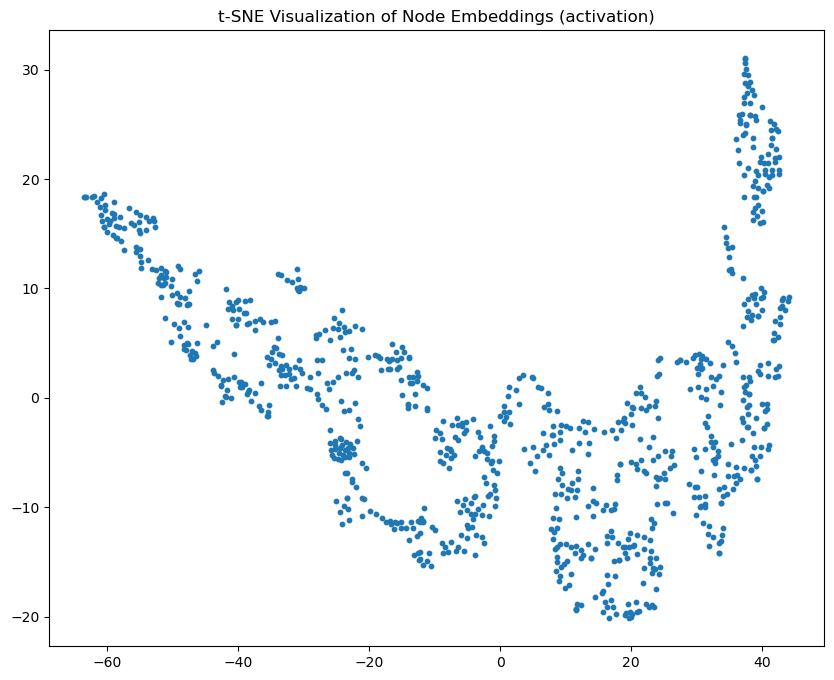


Processing binding mode...
Processing binding dataset...
Epoch: 001, Loss: 1.3856
Epoch: 002, Loss: 1.3850
Epoch: 003, Loss: 1.3845
Epoch: 004, Loss: 1.3840
Epoch: 005, Loss: 1.3835
Epoch: 006, Loss: 1.3830
Epoch: 007, Loss: 1.3824
Epoch: 008, Loss: 1.3818
Epoch: 009, Loss: 1.3812
Epoch: 010, Loss: 1.3805
Epoch: 011, Loss: 1.3797
Epoch: 012, Loss: 1.3788
Epoch: 013, Loss: 1.3778
Epoch: 014, Loss: 1.3766
Epoch: 015, Loss: 1.3753
Epoch: 016, Loss: 1.3738
Epoch: 017, Loss: 1.3721
Epoch: 018, Loss: 1.3702
Epoch: 019, Loss: 1.3680
Epoch: 020, Loss: 1.3657
Epoch: 021, Loss: 1.3630
Epoch: 022, Loss: 1.3601
Epoch: 023, Loss: 1.3568
Epoch: 024, Loss: 1.3532
Epoch: 025, Loss: 1.3494
Epoch: 026, Loss: 1.3452
Epoch: 027, Loss: 1.3408
Epoch: 028, Loss: 1.3363
Epoch: 029, Loss: 1.3316
Epoch: 030, Loss: 1.3270
Epoch: 031, Loss: 1.3227
Epoch: 032, Loss: 1.3188
Epoch: 033, Loss: 1.3156
Epoch: 034, Loss: 1.3124
Epoch: 035, Loss: 1.3100
Epoch: 036, Loss: 1.3086
Epoch: 037, Loss: 1.3078
Epoch: 038, Loss:

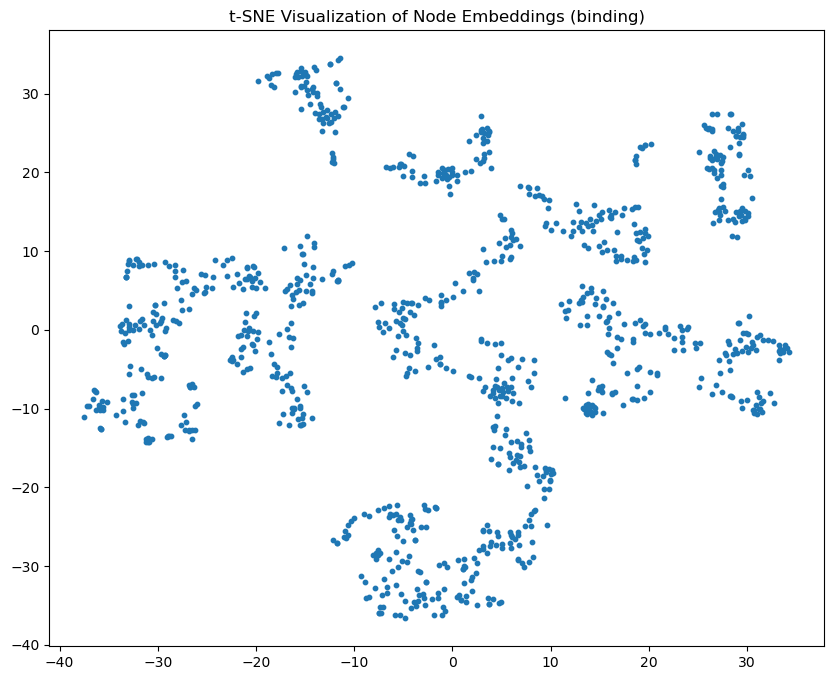


Processing catalysis mode...
Processing catalysis dataset...
Epoch: 001, Loss: 1.3836
Epoch: 002, Loss: 1.3816
Epoch: 003, Loss: 1.3817
Epoch: 004, Loss: 1.3808
Epoch: 005, Loss: 1.3799
Epoch: 006, Loss: 1.3794
Epoch: 007, Loss: 1.3789
Epoch: 008, Loss: 1.3780
Epoch: 009, Loss: 1.3773
Epoch: 010, Loss: 1.3766
Epoch: 011, Loss: 1.3758
Epoch: 012, Loss: 1.3748
Epoch: 013, Loss: 1.3741
Epoch: 014, Loss: 1.3732
Epoch: 015, Loss: 1.3722
Epoch: 016, Loss: 1.3712
Epoch: 017, Loss: 1.3701
Epoch: 018, Loss: 1.3689
Epoch: 019, Loss: 1.3678
Epoch: 020, Loss: 1.3665
Epoch: 021, Loss: 1.3652
Epoch: 022, Loss: 1.3637
Epoch: 023, Loss: 1.3621
Epoch: 024, Loss: 1.3605
Epoch: 025, Loss: 1.3587
Epoch: 026, Loss: 1.3567
Epoch: 027, Loss: 1.3545
Epoch: 028, Loss: 1.3522
Epoch: 029, Loss: 1.3497
Epoch: 030, Loss: 1.3469
Epoch: 031, Loss: 1.3438
Epoch: 032, Loss: 1.3405
Epoch: 033, Loss: 1.3368
Epoch: 034, Loss: 1.3328
Epoch: 035, Loss: 1.3285
Epoch: 036, Loss: 1.3238
Epoch: 037, Loss: 1.3186
Epoch: 038, L

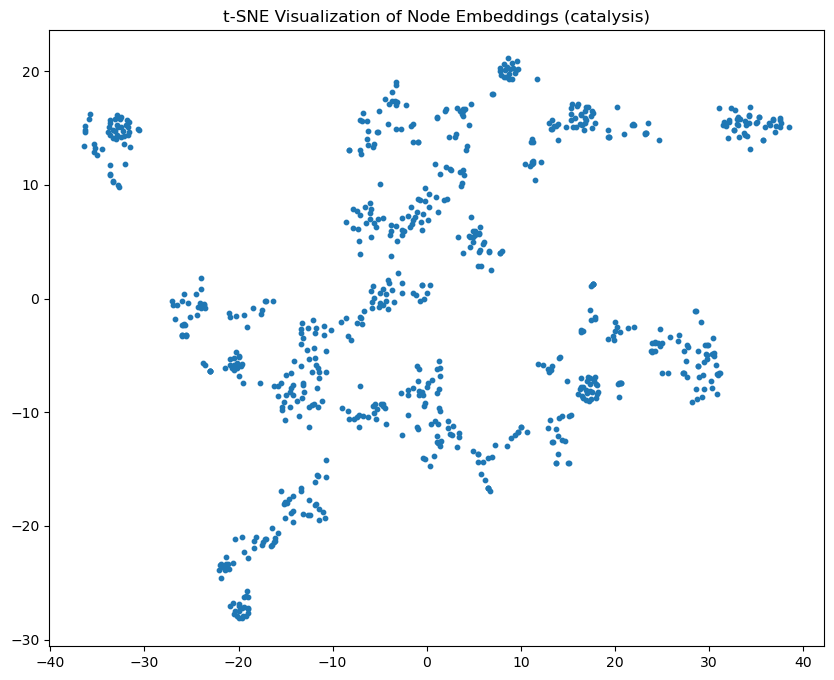


Processing expression mode...
Processing expression dataset...
Epoch: 001, Loss: 1.3722
Epoch: 002, Loss: 1.3524
Epoch: 003, Loss: 1.3271
Epoch: 004, Loss: 1.3097
Epoch: 005, Loss: 1.3152
Epoch: 006, Loss: 1.3183
Epoch: 007, Loss: 1.3075
Epoch: 008, Loss: 1.2978
Epoch: 009, Loss: 1.2945
Epoch: 010, Loss: 1.2945
Epoch: 011, Loss: 1.2940
Epoch: 012, Loss: 1.2912
Epoch: 013, Loss: 1.2864
Epoch: 014, Loss: 1.2808
Epoch: 015, Loss: 1.2763
Epoch: 016, Loss: 1.2741
Epoch: 017, Loss: 1.2735
Epoch: 018, Loss: 1.2718
Epoch: 019, Loss: 1.2681
Epoch: 020, Loss: 1.2640
Epoch: 021, Loss: 1.2613
Epoch: 022, Loss: 1.2601
Epoch: 023, Loss: 1.2590
Epoch: 024, Loss: 1.2571
Epoch: 025, Loss: 1.2543
Epoch: 026, Loss: 1.2518
Epoch: 027, Loss: 1.2504
Epoch: 028, Loss: 1.2498
Epoch: 029, Loss: 1.2485
Epoch: 030, Loss: 1.2464
Epoch: 031, Loss: 1.2447
Epoch: 032, Loss: 1.2439
Epoch: 033, Loss: 1.2434
Epoch: 034, Loss: 1.2424
Epoch: 035, Loss: 1.2411
Epoch: 036, Loss: 1.2402
Epoch: 037, Loss: 1.2398
Epoch: 038,

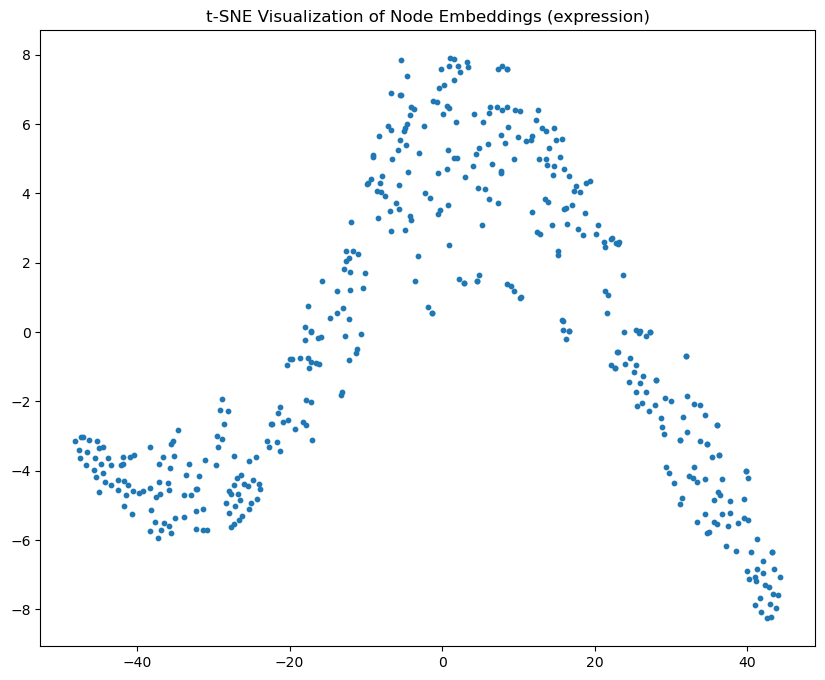


Processing inhibition mode...
Processing inhibition dataset...
Epoch: 001, Loss: 1.3838
Epoch: 002, Loss: 1.3777
Epoch: 003, Loss: 1.3704
Epoch: 004, Loss: 1.3656
Epoch: 005, Loss: 1.3653
Epoch: 006, Loss: 1.3646
Epoch: 007, Loss: 1.3599
Epoch: 008, Loss: 1.3559
Epoch: 009, Loss: 1.3543
Epoch: 010, Loss: 1.3531
Epoch: 011, Loss: 1.3509
Epoch: 012, Loss: 1.3477
Epoch: 013, Loss: 1.3444
Epoch: 014, Loss: 1.3422
Epoch: 015, Loss: 1.3406
Epoch: 016, Loss: 1.3381
Epoch: 017, Loss: 1.3353
Epoch: 018, Loss: 1.3330
Epoch: 019, Loss: 1.3312
Epoch: 020, Loss: 1.3294
Epoch: 021, Loss: 1.3270
Epoch: 022, Loss: 1.3247
Epoch: 023, Loss: 1.3227
Epoch: 024, Loss: 1.3206
Epoch: 025, Loss: 1.3180
Epoch: 026, Loss: 1.3161
Epoch: 027, Loss: 1.3140
Epoch: 028, Loss: 1.3115
Epoch: 029, Loss: 1.3092
Epoch: 030, Loss: 1.3070
Epoch: 031, Loss: 1.3044
Epoch: 032, Loss: 1.3019
Epoch: 033, Loss: 1.2993
Epoch: 034, Loss: 1.2964
Epoch: 035, Loss: 1.2938
Epoch: 036, Loss: 1.2908
Epoch: 037, Loss: 1.2876
Epoch: 038,

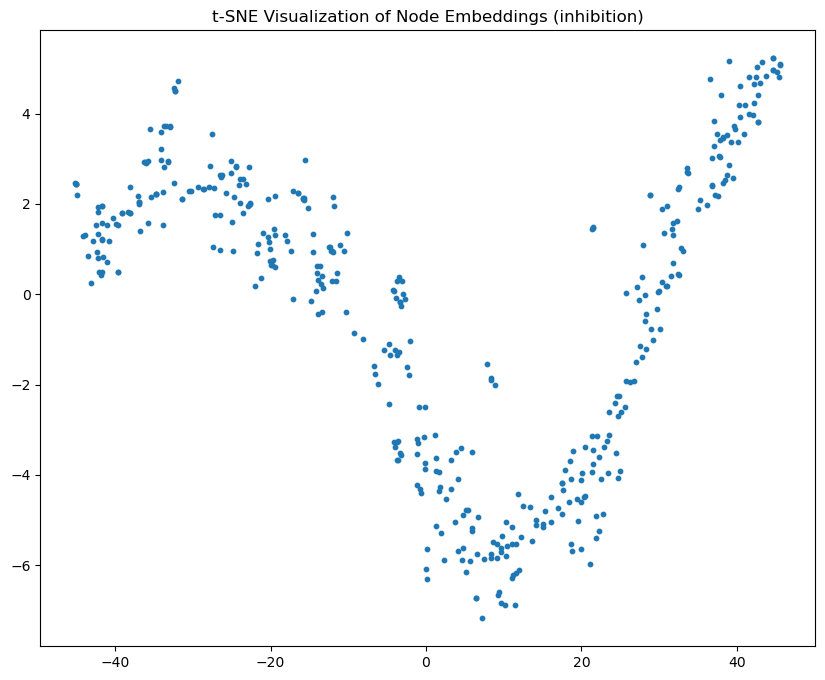


Processing ptmod mode...
Processing ptmod dataset...
Epoch: 001, Loss: 1.3743
Epoch: 002, Loss: 1.3601
Epoch: 003, Loss: 1.3435
Epoch: 004, Loss: 1.3330
Epoch: 005, Loss: 1.3350
Epoch: 006, Loss: 1.3353
Epoch: 007, Loss: 1.3276
Epoch: 008, Loss: 1.3215
Epoch: 009, Loss: 1.3204
Epoch: 010, Loss: 1.3195
Epoch: 011, Loss: 1.3169
Epoch: 012, Loss: 1.3128
Epoch: 013, Loss: 1.3083
Epoch: 014, Loss: 1.3053
Epoch: 015, Loss: 1.3042
Epoch: 016, Loss: 1.3026
Epoch: 017, Loss: 1.2992
Epoch: 018, Loss: 1.2957
Epoch: 019, Loss: 1.2937
Epoch: 020, Loss: 1.2923
Epoch: 021, Loss: 1.2903
Epoch: 022, Loss: 1.2875
Epoch: 023, Loss: 1.2850
Epoch: 024, Loss: 1.2836
Epoch: 025, Loss: 1.2822
Epoch: 026, Loss: 1.2798
Epoch: 027, Loss: 1.2780
Epoch: 028, Loss: 1.2769
Epoch: 029, Loss: 1.2752
Epoch: 030, Loss: 1.2731
Epoch: 031, Loss: 1.2716
Epoch: 032, Loss: 1.2703
Epoch: 033, Loss: 1.2684
Epoch: 034, Loss: 1.2669
Epoch: 035, Loss: 1.2658
Epoch: 036, Loss: 1.2640
Epoch: 037, Loss: 1.2625
Epoch: 038, Loss: 1.2

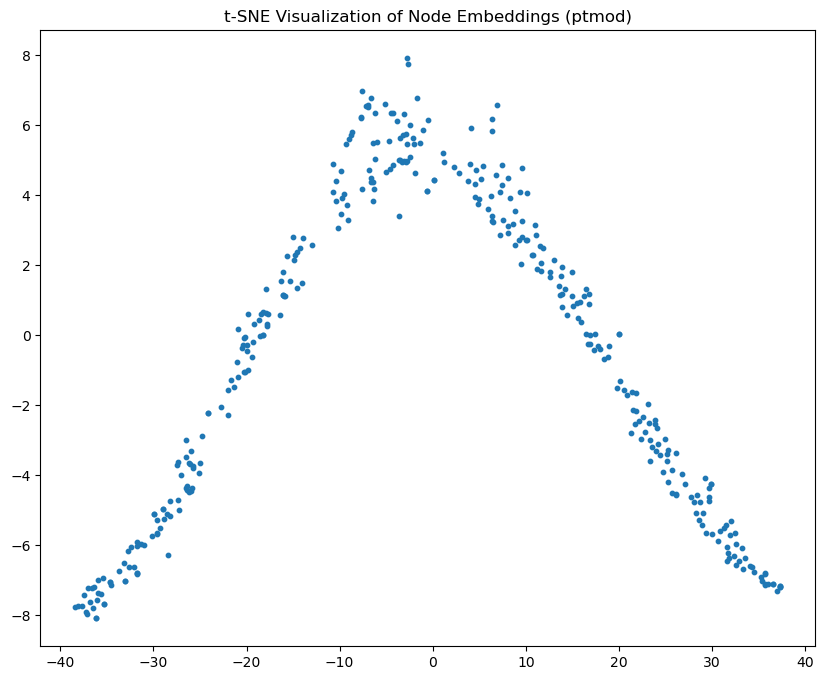


Processing reaction mode...
Processing reaction dataset...
Epoch: 001, Loss: 1.3862
Epoch: 002, Loss: 1.3852
Epoch: 003, Loss: 1.3844
Epoch: 004, Loss: 1.3840
Epoch: 005, Loss: 1.3836
Epoch: 006, Loss: 1.3831
Epoch: 007, Loss: 1.3825
Epoch: 008, Loss: 1.3819
Epoch: 009, Loss: 1.3812
Epoch: 010, Loss: 1.3803
Epoch: 011, Loss: 1.3795
Epoch: 012, Loss: 1.3785
Epoch: 013, Loss: 1.3774
Epoch: 014, Loss: 1.3761
Epoch: 015, Loss: 1.3747
Epoch: 016, Loss: 1.3732
Epoch: 017, Loss: 1.3714
Epoch: 018, Loss: 1.3694
Epoch: 019, Loss: 1.3673
Epoch: 020, Loss: 1.3651
Epoch: 021, Loss: 1.3625
Epoch: 022, Loss: 1.3597
Epoch: 023, Loss: 1.3567
Epoch: 024, Loss: 1.3534
Epoch: 025, Loss: 1.3499
Epoch: 026, Loss: 1.3460
Epoch: 027, Loss: 1.3420
Epoch: 028, Loss: 1.3378
Epoch: 029, Loss: 1.3334
Epoch: 030, Loss: 1.3290
Epoch: 031, Loss: 1.3254
Epoch: 032, Loss: 1.3205
Epoch: 033, Loss: 1.3158
Epoch: 034, Loss: 1.3123
Epoch: 035, Loss: 1.3081
Epoch: 036, Loss: 1.3038
Epoch: 037, Loss: 1.3003
Epoch: 038, Los

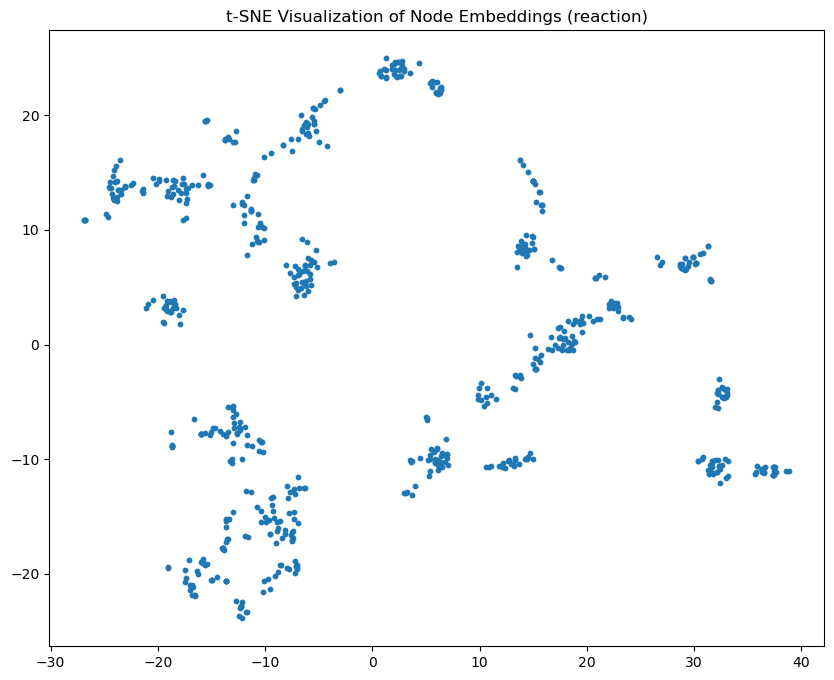


Processing combined mode...
Processing combined dataset...
Epoch: 001, Loss: 1.3851
Epoch: 002, Loss: 1.3815
Epoch: 003, Loss: 1.3759
Epoch: 004, Loss: 1.3684
Epoch: 005, Loss: 1.3611
Epoch: 006, Loss: 1.3566
Epoch: 007, Loss: 1.3556
Epoch: 008, Loss: 1.3555
Epoch: 009, Loss: 1.3516
Epoch: 010, Loss: 1.3470
Epoch: 011, Loss: 1.3450
Epoch: 012, Loss: 1.3436
Epoch: 013, Loss: 1.3413
Epoch: 014, Loss: 1.3385
Epoch: 015, Loss: 1.3356
Epoch: 016, Loss: 1.3331
Epoch: 017, Loss: 1.3311
Epoch: 018, Loss: 1.3295
Epoch: 019, Loss: 1.3271
Epoch: 020, Loss: 1.3241
Epoch: 021, Loss: 1.3215
Epoch: 022, Loss: 1.3193
Epoch: 023, Loss: 1.3172
Epoch: 024, Loss: 1.3146
Epoch: 025, Loss: 1.3124
Epoch: 026, Loss: 1.3107
Epoch: 027, Loss: 1.3084
Epoch: 028, Loss: 1.3059
Epoch: 029, Loss: 1.3041
Epoch: 030, Loss: 1.3022
Epoch: 031, Loss: 1.2999
Epoch: 032, Loss: 1.2982
Epoch: 033, Loss: 1.2965
Epoch: 034, Loss: 1.2943
Epoch: 035, Loss: 1.2925
Epoch: 036, Loss: 1.2907
Epoch: 037, Loss: 1.2890
Epoch: 038, Los

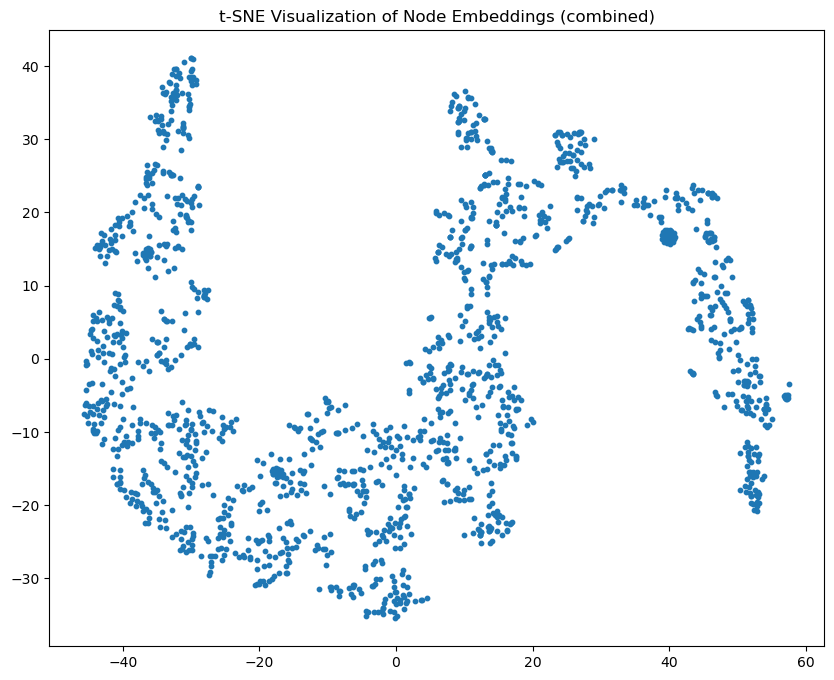

In [10]:
# Process each dataframe and store results
results = {}

dataframes = {
    "activation": df_activation,
    "binding": df_binding,
    "catalysis": df_catalysis,
    "expression": df_expression,
    "inhibition": df_inhibition,
    "ptmod": df_ptmod,
    "reaction": df_reaction,
    "combined": df_combined
}

for mode_name, df in dataframes.items():
    print(f"\nProcessing {mode_name} mode...")
    results[mode_name] = process_dataframe(df, mode_name)

In [11]:
# Print results for all modes
for mode_name, result in results.items():
    print(f"\n{mode_name.capitalize()} Mode Results:")
    print(f"Validation AUC-ROC: {result['val_auc_roc']:.4f}")
    print(f"Validation AUC-PR: {result['val_auc_pr']:.4f}")
    print(f"Test AUC-ROC: {result['test_auc_roc']:.4f}")
    print(f"Test AUC-PR: {result['test_auc_pr']:.4f}")


Activation Mode Results:
Validation AUC-ROC: 0.7366
Validation AUC-PR: 0.7378
Test AUC-ROC: 0.7714
Test AUC-PR: 0.7765

Binding Mode Results:
Validation AUC-ROC: 0.8282
Validation AUC-PR: 0.8066
Test AUC-ROC: 0.7777
Test AUC-PR: 0.7640

Catalysis Mode Results:
Validation AUC-ROC: 0.8151
Validation AUC-PR: 0.8000
Test AUC-ROC: 0.8211
Test AUC-PR: 0.8048

Expression Mode Results:
Validation AUC-ROC: 0.6863
Validation AUC-PR: 0.7599
Test AUC-ROC: 0.6961
Test AUC-PR: 0.7816

Inhibition Mode Results:
Validation AUC-ROC: 0.8154
Validation AUC-PR: 0.7827
Test AUC-ROC: 0.8190
Test AUC-PR: 0.7866

Ptmod Mode Results:
Validation AUC-ROC: 0.7392
Validation AUC-PR: 0.7035
Test AUC-ROC: 0.7923
Test AUC-PR: 0.7874

Reaction Mode Results:
Validation AUC-ROC: 0.8090
Validation AUC-PR: 0.7683
Test AUC-ROC: 0.8291
Test AUC-PR: 0.8088

Combined Mode Results:
Validation AUC-ROC: 0.7923
Validation AUC-PR: 0.7778
Test AUC-ROC: 0.8013
Test AUC-PR: 0.8079
